# 7.5 PCアルゴリズムによるベイジアンネットワーク探索の実装

本ファイルは、7.5節の実装です。

5.3節で使用した人事研修の効果を拡張した模擬データを作成し、因果探索を実施します。

## プログラム実行前の設定など

In [0]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


In [0]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd


## データの作成

In [0]:
# データ数
num_data = 2000

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 


In [0]:
# 本章からの追加データを生成

# Y2：部下当人のチームメンバへの満足度 1から5の5段階
Y2 = np.random.choice([1.0, 2.0, 3.0, 4.0, 5.0],
                      num_data, p=[0.1, 0.2, 0.3, 0.2, 0.2])

# Y3：部下当人の仕事への満足度
e_y3 = randn(num_data)
Y3 = 3*Y + Y2 + e_y3

# Y4：部下当人の仕事のパフォーマンス
e_y4 = randn(num_data)
Y4 = 3*Y3 + 5 + 2*e_y4 


## データをまとめた表を作成し、可視化する

In [5]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   'Y2': Y2,
                   'Y3': Y3,
                   'Y4': Y4,
                   })

df.head()  # 先頭を表示


,x,Z,t,Y,Y2,Y3,Y4
0,-0.616961,1.0,0.5,2.286924,2.0,8.732544,30.326507
1,0.244218,1.0,0.7,2.864636,3.0,10.743959,37.149014
2,-0.124545,0.0,0.5,2.198515,3.0,10.569163,38.481185
3,0.570717,1.0,1.0,3.230572,3.0,12.312526,43.709229
4,0.559952,0.0,1.0,2.459267,5.0,12.418739,40.833938


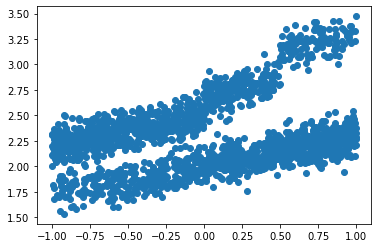

In [6]:
# グラフで確認
plt.scatter(x, Y)


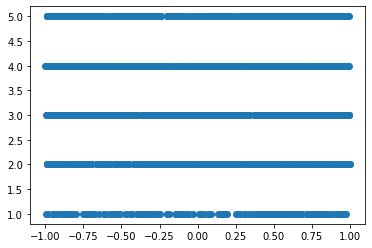

In [7]:
# グラフで確認
plt.scatter(x, Y2)


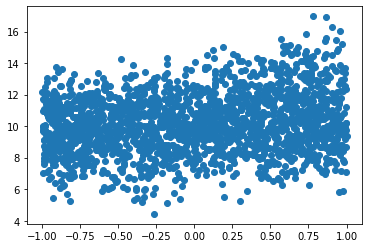

In [8]:
# グラフで確認
plt.scatter(x, Y3)


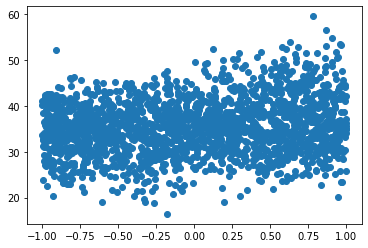

In [9]:
# グラフで確認
plt.scatter(x, Y4)


## データをビンで区切る

In [10]:
# ビン区切りの例
# cutを使用すると閾値で区切れる
# qcutを使用すると同じデータ数になるように区切る
s_qcut, bins = pd.cut(df["Y"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

print(s_qcut)
print("=======")
print(bins)


0       2
1       4
2       2
3       5
4       3
       ..
1995    2
1996    2
1997    2
1998    2
1999    2
Name: Y, Length: 2000, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
[1.532537   1.92223596 2.30999611 2.69775627 3.08551643 3.47327659]


In [11]:
# データを区切る
df_bin = df.copy()  # コピーしてビン区切りデータを入れる変数を作成
del df_bin["t"]  # 変数tは観測できないので削除

# x：部下育成への熱心さ
df_bin["x"], x_bins = pd.cut(df["x"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Z：上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
# ※qcutではなく、cutで値に応じて分割
df_bin["Z"], z_bins = pd.cut(df["Z"], 2, labels=[0, 1], retbins=True)

# Y：部下の面談の満足度
df_bin["Y"], y_bins = pd.cut(df["Y"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y2：部下当人のチームメンバへの満足度 1から5の5段階
# # ※qcutではなく、cutで値に応じて分割
df_bin["Y2"], y2_bins = pd.cut(
    df["Y2"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y3：部下当人の仕事への満足度
df_bin["Y3"], y3_bins = pd.cut(
    df["Y3"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y4：部下当人の仕事のパフォーマンス
df_bin["Y4"], y4_bins = pd.cut(
    df["Y4"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# 確認
df_bin.head()


,x,Z,Y,Y2,Y3,Y4
0,1,1,2,2,2,2
1,4,1,4,3,3,3
2,3,0,2,3,3,3
3,4,1,5,3,4,4
4,4,0,3,5,4,3


In [0]:
#df_bin=df_bin.astype(int)

## PCアルゴリズムを実施

## pgmpy（Python library for Probabilistic Graphical Models）によるPCアルゴリズム

In [13]:
!pip install pgmpy==0.1.9

     |████████████████████████████████| 337kB 4.5MB/s 


In [14]:
from pgmpy.estimators import ConstraintBasedEstimator

est = ConstraintBasedEstimator(df_bin)

# 0次の独立性の検定
print(est.test_conditional_independence(
    'x', 'Z', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Z', 'Y', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y2', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y2', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y3', 'Y4', method="chi_square", tol=0.05))
print("=====")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


False
False
True
False
False
=====
False
True
False
False
=====
True
False
False
=====
False
False
=====
False
=====


In [15]:
# 1次の独立性の検定 変数x
print(est.test_conditional_independence(
    'x', 'Z', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Z', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Z', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y3', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y4', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', ['Y3'], method="chi_square", tol=0.05))


False
False
False
False
False
False
False
True
True
False
True
True


In [16]:
# 1次の独立性の検定 変数Z
print(est.test_conditional_independence(
    'Z', 'x', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'x', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'x', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y3', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y4', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', ['Y3'], method="chi_square", tol=0.05))


False
False
False
False
False
False
False
True
False
False
True
True


In [17]:
# 1次の独立性の検定 変数Y
print(est.test_conditional_independence(
    'Y', 'x', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'x', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'x', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Z', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Y3', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Y4', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', ['Y3'], method="chi_square", tol=0.05))


False
False
False
False
False
False
False
False
False
False
False
True


In [18]:
# 1次の独立性の検定 変数Y2
print(est.test_conditional_independence(
    'Y2', 'Y3', ['Y4'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y2', 'Y4', ['Y3'], method="chi_square", tol=0.05))


False
True


In [19]:
# 1次の独立性の検定 変数Y
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y2'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y2'], method="chi_square", tol=0.05))


False
False
False
False
False
False


In [20]:
# オリエンテーション・フェーズ1での方向づけ
# x-Y-Y3
print(est.test_conditional_independence(
    'x', 'Y3', ['Y'], method="chi_square", tol=0.05))

# Z-Y-Y3
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y'], method="chi_square", tol=0.05))

# Y-Y3-Y2
print(est.test_conditional_independence(
    'Y', 'Y2', ['Y3'], method="chi_square", tol=0.05))

# Y2-Y3-Y4
print(est.test_conditional_independence(
    'Y2', 'Y4', ['Y3'], method="chi_square", tol=0.05))

# Y -> Y3 <- Y2 だけ決まる


True
True
False
True


In [21]:
# 最後上の三角形が決まらない
# BICを求め、比較
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore

model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Z', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Y', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Z', 'x'), ('Z', 'Y'), ('x', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Z', 'x'), ('Z', 'Y'), ('Y', 'x'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Y', 'x'), ('Y', 'Z'), ('x', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Y', 'x'), ('Y', 'Z'), ('Z', 'x'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

-11844.323296552853
-11844.323296552853
-11844.323296552855
-11844.323296552855
-11844.323296552853
-11844.323296552855


In [0]:
# 最後は限られたデータから無理に因果の方向性を決めようとせず、時間的に考えて、無難な方向性を当てはめる

## ベイジアンネットワークでの推論

In [23]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

# モデルを構築
model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Z', 'Y'),
                       ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])
# モデルにデータを与える
model.fit(df_bin)

# 変数消去アルゴリズムで推論
infer = VariableElimination(model)
obserbed_data = {'Z': 0, 'Y3': 3}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)
print("=====================")
obserbed_data = {'Z': 1, 'Y3': 3}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)
print("=====================")
obserbed_data = {'Z': 1, 'Y3': 5}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)


Eliminating: Y: 100%|██████████| 3/3 [00:00<00:00, 284.88it/s]

+------+----------+
| x    |   phi(x) |
+======+==========+
| x(1) |   0.0593 |
+------+----------+
| x(2) |   0.1029 |
+------+----------+
| x(3) |   0.1983 |
+------+----------+
| x(4) |   0.2692 |
+------+----------+
| x(5) |   0.3703 |
+------+----------+
+------+----------+
| x    |   phi(x) |
+======+==========+
| x(1) |   0.3715 |
+------+----------+
| x(2) |   0.2326 |
+------+----------+
| x(3) |   0.2290 |
+------+----------+
| x(4) |   0.1138 |
+------+----------+
| x(5) |   0.0532 |
+------+----------+



Eliminating: Y: 100%|██████████| 3/3 [00:00<00:00, 553.19it/s]

+------+----------+
| x    |   phi(x) |
+======+==========+
| x(1) |   0.0074 |
+------+----------+
| x(2) |   0.0107 |
+------+----------+
| x(3) |   0.0689 |
+------+----------+
| x(4) |   0.2942 |
+------+----------+
| x(5) |   0.6188 |
+------+----------+


In [0]:
# 以下はファイルをダウンロードしたい場合に使用

# from google.colab import files
# df_bin.to_csv("df_bin.csv")
# files.download('df_bin.csv')


以上